In [14]:
pip install darts


[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [15]:
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [16]:
import pandas as pd

# Hourly price

data_2023 = [pd.read_csv(f"Data/messari_hourly_prices/hourly_prices_2023_{i}.csv", parse_dates=["datetime"]) for i in range(1, 13)]
data_2024 = [pd.read_csv(f"Data/messari_hourly_prices/hourly_prices_2024_{i}.csv", parse_dates=["datetime"]) for i in range(1, 13)]
df1 = pd.concat(data_2023 + data_2024).sort_values("datetime").set_index("datetime").drop(columns=["Unnamed: 0"])

df1 = df1.reset_index()
df1_btc = df1[df1['reserve_name']=='Wrapped BTC']

# Reserves features

data2_2023 = [pd.read_csv(f"Data/reserves_features/reserves_history_hourly_completed_2023-{i}.csv") for i in range(1, 13)]
data2_2024 = [pd.read_csv(f"Data/reserves_features/reserves_history_hourly_completed_2024-{i}.csv") for i in range(1, 13)]
dfr = pd.concat(data2_2023 + data2_2024).drop(columns=["Unnamed: 0"])

dfr_btc = dfr[dfr['reserve_name']=='Wrapped BTC'].dropna().drop(["totalPrincipalStableDebt"], axis=1)

# Merge

dfr_btc['regular_datetime'] = pd.to_datetime(dfr_btc['regular_datetime'], utc=True)
df_btc = pd.merge(df1_btc, dfr_btc, left_on='datetime', right_on='regular_datetime')
df_btc = df_btc.drop(['blockNumber', 'timestamp_hours', 'id', 'snapshot_timestamp', 
'regular_datetime', 'reserve_name_x', 'reserve_name_y', 'reserve_pool', 'protocol', 'protocol_name', 
'priceInUsd', 'outputTokenPriceUSD', 'averageStableBorrowRate', 'priceInEth', 'reserve_decimals', 
'true_value', 'timestamp'], axis=1)

df_btc = df_btc.sort_values("datetime")
df_btc = df_btc.iloc[:, :2]
df_btc['datetime'] = df_btc['datetime'].dt.tz_localize(None)
df_btc

,datetime,inputTokenPriceUSD
0,2023-01-27 12:00:00,22901.415798
1,2023-01-27 13:00:00,22889.291609
2,2023-01-27 14:00:00,22840.819903
3,2023-01-27 15:00:00,22979.545483
4,2023-01-27 16:00:00,23008.788367
...,...,...
14018,2024-12-31 19:00:00,93759.525729
14019,2024-12-31 20:00:00,93759.525729
14020,2024-12-31 21:00:00,93271.901873
14021,2024-12-31 22:00:00,93512.722731


In [17]:
df_btc = df_btc.set_index('datetime')

# Find missing hours (there are 2885 in total) because it is crucial to not have them for TimeSeries objects
expected = pd.date_range(start=df_btc.index.min(), end=df_btc.index.max(), freq='H')
missing_hours = expected.difference(df_btc.index)

missing_hours

DatetimeIndex(['2023-01-27 18:00:00', '2023-01-27 19:00:00',
               '2023-01-27 21:00:00', '2023-01-27 22:00:00',
               '2023-01-27 23:00:00', '2023-01-28 00:00:00',
               '2023-01-28 02:00:00', '2023-01-28 04:00:00',
               '2023-01-28 06:00:00', '2023-01-28 09:00:00',
               ...
               '2024-12-12 07:00:00', '2024-12-14 13:00:00',
               '2024-12-21 02:00:00', '2024-12-22 18:00:00',
               '2024-12-25 08:00:00', '2024-12-26 03:00:00',
               '2024-12-27 13:00:00', '2024-12-29 03:00:00',
               '2024-12-29 09:00:00', '2024-12-31 07:00:00'],
              dtype='datetime64[ns]', length=2885, freq=None)

In [ ]:
full_index = df_btc.index.union(missing_hours).sort_values() # new index with no missing hours
df_btc = df_btc.reindex(full_index)
df_btc['inputTokenPriceUSD'] = df_btc['inputTokenPriceUSD'].ffill() # filling price with the price before
df_btc = df_btc.reset_index() # to transform to TimeSeries

df_btc


16908

In [20]:
# Transform the dataframe into TimeSeries
from darts import TimeSeries

df_btc = TimeSeries.from_dataframe(df_btc, time_col="datetime", fill_missing_dates=True, freq="h")

# test=TimeSeries.from_dataframe(df_btc, time_col="datetime", fill_missing_dates=True, freq="h")
# test.plot()

In [21]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [22]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler
from darts.datasets import AirPassengersDataset, IceCreamHeaterDataset
from darts.metrics import mape
from darts.models import TFTModel
from darts.utils.likelihood_models.torch import QuantileRegression
from darts.utils.statistics import check_seasonality, plot_acf
from darts.utils.timeseries_generation import datetime_attribute_timeseries

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

/usr/local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [23]:
# Create training and validation sets
training_cutoff = pd.Timestamp("20240101")
train, val = df_btc.split_after(training_cutoff)
train

<TimeSeries (DataArray) (datetime: 8125, component: 1, sample: 1)> Size: 65kB
array([[[22901.415798  ]],

       [[22889.29160854]],

       [[22840.8199029 ]],

       ...,

       [[42237.80708925]],

       [[42297.13627061]],

       [[42423.92495031]]], shape=(8125, 1, 1))
Coordinates:
  * datetime   (datetime) datetime64[ns] 65kB 2023-01-27T12:00:00 ... 2024-01-01
  * component  (component) <U18 72B 'inputTokenPriceUSD'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
    metadata:           None

In [24]:
# Normalize the time series
transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(df_btc)

In [25]:
# Create year, month and integer index covariate series
covariates = datetime_attribute_timeseries(df_btc, attribute="year", one_hot=False)
covariates = covariates.stack(
    datetime_attribute_timeseries(df_btc, attribute="month", one_hot=False)
)
covariates = covariates.stack(
    TimeSeries.from_times_and_values(
        times=df_btc.time_index,
        values=np.arange(len(df_btc)),
        columns=["linear_increase"],
    )
)
covariates = covariates.astype(np.float32)
covariates

<TimeSeries (DataArray) (datetime: 16908, component: 3, sample: 1)> Size: 203kB
array([[[2.0230e+03],
        [0.0000e+00],
        [0.0000e+00]],

       [[2.0230e+03],
        [0.0000e+00],
        [1.0000e+00]],

       [[2.0230e+03],
        [0.0000e+00],
        [2.0000e+00]],

       ...,

       [[2.0240e+03],
        [1.1000e+01],
        [1.6905e+04]],

       [[2.0240e+03],
        [1.1000e+01],
        [1.6906e+04]],

       [[2.0240e+03],
        [1.1000e+01],
        [1.6907e+04]]], shape=(16908, 3, 1), dtype=float32)
Coordinates:
  * datetime   (datetime) datetime64[ns] 135kB 2023-01-27T12:00:00 ... 2024-1...
  * component  (component) object 24B 'year' 'month' 'linear_increase'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
    metadata:           None

In [26]:
# Transform covariates
scaler_covs = Scaler()
cov_train, cov_val = covariates.split_after(training_cutoff)
scaler_covs.fit(cov_train)
covariates_transformed = scaler_covs.transform(covariates)

In [27]:
# Default quantiles for QuantileRegression
quantiles = [
    0.01,
    0.05,
    0.1,
    0.15,
    0.2,
    0.25,
    0.3,
    0.4,
    0.5,
    0.6,
    0.7,
    0.75,
    0.8,
    0.85,
    0.9,
    0.95,
    0.99,
]
input_chunk_length = 24
forecast_horizon = 12
my_model = TFTModel(
    input_chunk_length=input_chunk_length,
    output_chunk_length=forecast_horizon,
    hidden_size=64,
    lstm_layers=1,
    num_attention_heads=4,
    dropout=0.1,
    batch_size=16,
    n_epochs=10, # takes me approximately 5min for 1 epoch
    add_relative_index=False,
    add_encoders=None,
    likelihood=QuantileRegression(
        quantiles=quantiles
    ),  # QuantileRegression is set per default
    # loss_fn=MSELoss(),
    random_state=42,
)

# For Probabilistic Forecast: likelihood=MyLikelihood()
# For Deterministic Forecast: likelihood=None, loss_fn=torch.nn.MSELoss()

In [28]:
# Train the TFT (82min for 19 epochs; stopped)
my_model.fit(train_transformed, future_covariates=covariates_transformed, verbose=True)

Epoch 9: 100%|██████████| 506/506 [02:45<00:00,  3.07it/s, train_loss=nan.0]


TFTModel(output_chunk_shift=0, hidden_size=64, lstm_layers=1, num_attention_heads=4, full_attention=False, feed_forward=GatedResidualNetwork, dropout=0.1, hidden_continuous_size=8, categorical_embedding_sizes=None, add_relative_index=False, loss_fn=None, likelihood=QuantileRegression(quantiles=[0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99], prior_strength=1.0), norm_type=LayerNorm, use_static_covariates=True, input_chunk_length=24, output_chunk_length=12, batch_size=16, n_epochs=10, add_encoders=None, random_state=42)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:02<00:00,  2.53s/it]


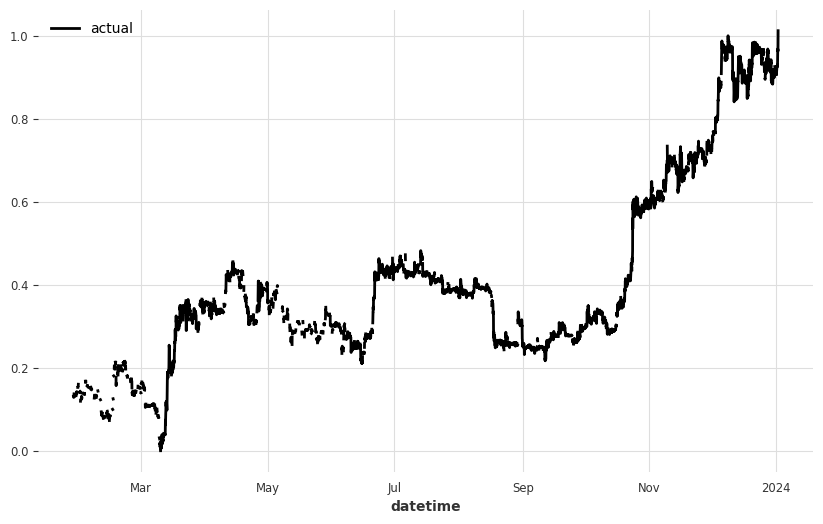

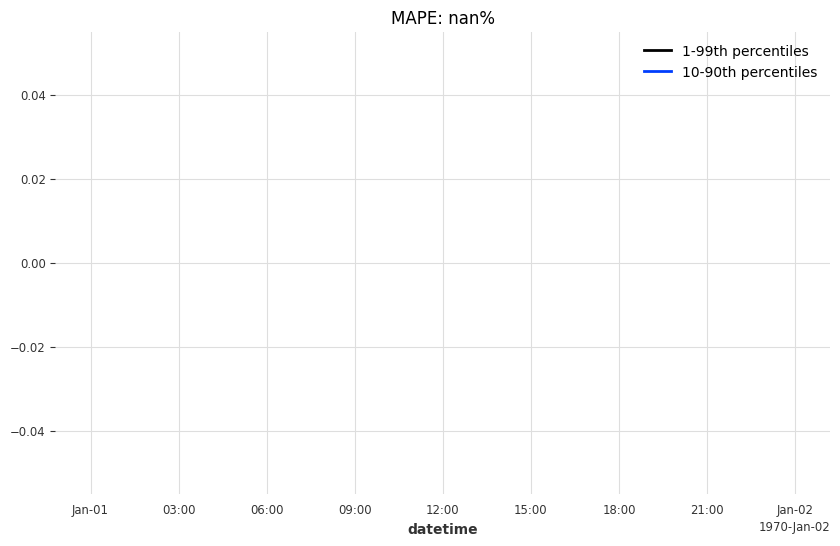

In [ ]:
# Predictions on the validation set
num_samples = 200

figsize = (10, 6)
lowest_q, low_q, high_q, highest_q = 0.01, 0.1, 0.9, 0.99
label_q_outer = f"{int(lowest_q * 100)}-{int(highest_q * 100)}th percentiles"
label_q_inner = f"{int(low_q * 100)}-{int(high_q * 100)}th percentiles"


def eval_model(model, n, actual_series, val_series):
    pred_series = model.predict(n=n, num_samples=num_samples)

    # plot actual series
    plt.figure(figsize=figsize)
    actual_series[: pred_series.end_time()].plot(label="actual")

    # plot prediction with quantile ranges
    pred_series.plot(
        low_quantile=lowest_q, high_quantile=highest_q, label=label_q_outer
    )
    pred_series.plot(low_quantile=low_q, high_quantile=high_q, label=label_q_inner)

    plt.title(f"MAPE: {mape(val_series, pred_series):.2f}%")
    plt.legend()


eval_model(my_model, 24, series_transformed, val_transformed)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.05it/s]


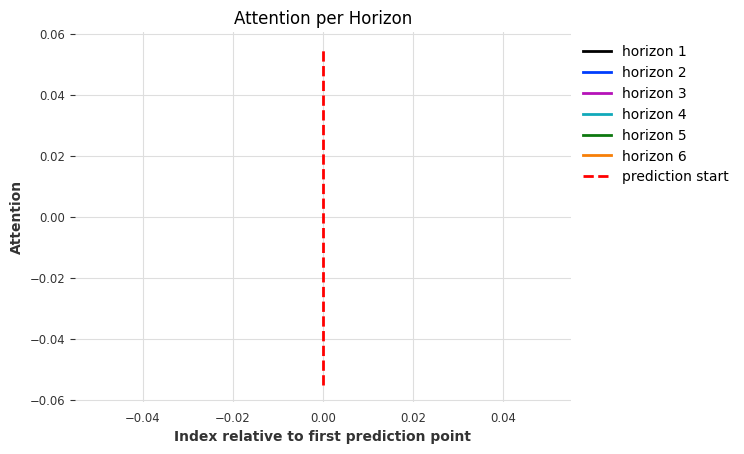

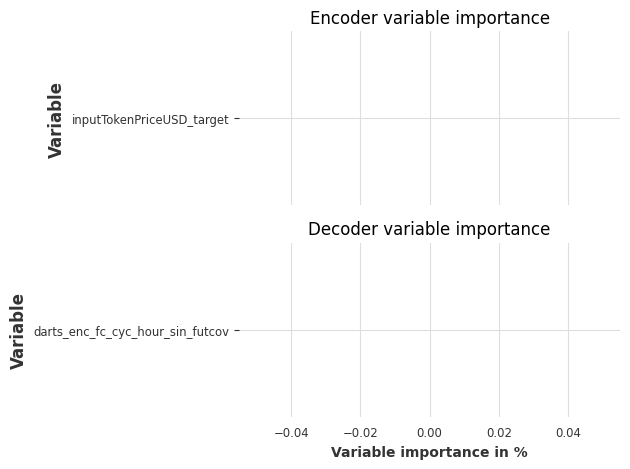

In [33]:
from darts.explainability.tft_explainer import TFTExplainer
from darts.models import TFTModel

model = TFTModel(
    input_chunk_length=12,
    output_chunk_length=6,
    add_encoders={"cyclic": {"future": ["hour"]}},
    n_epochs=1
)
model.fit(df_btc)
# create the explainer and generate explanations
explainer = TFTExplainer(model)
results = explainer.explain()
# plot the results
explainer.plot_attention(results, plot_type="all")
explainer.plot_variable_selection(results)

In [36]:
pred_series = my_model.predict(n=24, num_samples=num_samples)
pred_series

Predicting DataLoader 0: 100%|██████████| 1/1 [00:02<00:00,  2.31s/it]


<TimeSeries (DataArray) (datetime: 24, component: 1, sample: 200)> Size: 38kB
array([[[nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan]],

       ...,

       [[nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan]]], shape=(24, 1, 200))
Coordinates:
  * datetime   (datetime) datetime64[ns] 192B 2024-01-01T01:00:00 ... 2024-01-02
  * component  (component) object 8B 'inputTokenPriceUSD'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
    metadata:           None